**Purpose:** Extract and plot the TIaaS stats

In [1]:
import datetime
import matplotlib.pyplot as plt
import pandas as pd
import pycountry_convert as pc

In [2]:
continents = {
    'NA': 'North America',
    'SA': 'South America', 
    'AS': 'Asia',
    'OC': 'Australia',
    'AF': 'Africa',
    'EU': 'Europe'
}

def get_continent(c):
    '''Extract continent name from a country code'''
    return continents[pc.country_alpha2_to_continent_code(c)]

def get_continents(c):
    '''Extract continent from country codes'''
    if '|' in c:
        cs = c.split('|')
        return '|'.join(set([get_continent(d) for d in cs]))
    else:
        return get_continent(c)

In [3]:
df = (pd.read_csv('https://usegalaxy.eu/tiaas/numbers.csv', sep=',', index_col=0)
      # transform Y / N to True / False
     .replace("Y", True)
     .replace("N", False)
     .assign(
         start=lambda x: pd.to_datetime(x['start'], format='%Y-%m-%d'),
         end=lambda x: pd.to_datetime(x['end'], format='%Y-%m-%d'),
         month=lambda x: x['start'].dt.to_period('M'),
         year=lambda x: x['start'].dt.to_period('Y'),
         continent=lambda x: [get_continents(y) for y in x['location']]))
df

,start,end,location,use_gtn,attendance,month,year,continent
id,,,,,,,,
403,2021-04-26,2021-04-30,PK,False,50,2021-04,2021,Asia
322,2020-11-12,2020-11-30,FR,False,25,2020-11,2020,Europe
267,2020-02-21,2020-05-22,CZ,True,24,2020-02,2020,Europe
279,2020-05-18,2020-06-18,GB,True,40,2020-05,2020,Europe
326,2020-08-27,2020-12-17,US,False,12,2020-08,2020,North America
...,...,...,...,...,...,...,...,...
242,2019-12-02,2019-12-06,FR,False,17,2019-12,2019,Europe
389,2021-03-22,2021-03-23,UG,True,20,2021-03,2021,Africa
393,2021-04-26,2021-04-30,GB,True,35,2021-04,2021,Europe


# General stats

Stats collected in timeframe

In [4]:
"%s - %s" % (min(df['start']), max(df['start']))

'2018-06-20 00:00:00 - 2021-11-29 00:00:00'

Number of TIaaS events

In [5]:
len(df)

229

Percentage of TIaaS events using GTN

In [6]:
sum(df.use_gtn)/len(df)*100

63.75545851528385

Total number of participants

In [7]:
sum(df.attendance)

8411

# Evolution over the months

In [8]:
nb_per_months_df = (df
    .groupby(df.month)
    .agg({'start': ['count'], 'attendance': ['sum']}))
nb_per_months_df.columns = ['Events', 'Participants']
nb_per_months_df.head()

,Events,Participants
month,,
2018-06,3,57
2018-07,1,60
2018-08,1,30
2018-09,4,75
2018-10,4,85


Average number of events per months

In [9]:
sum(nb_per_months_df.Events)/len(nb_per_months_df)

5.585365853658536

<Figure size 432x288 with 0 Axes>

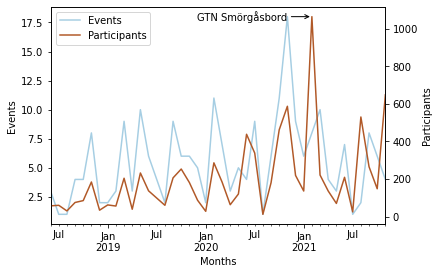

In [10]:
plt.figure()
ax = nb_per_months_df.plot(colormap='Paired', secondary_y=['Participants'], mark_right=False)
ax.set_xlabel('Months')
ax.set_ylabel('Events')
ax.right_ax.set_ylabel('Participants')
plt.annotate(
    'GTN Smörgåsbord',
    xy=('2021-02-15', nb_per_months_df['Participants']['2021-02']),
    xycoords='data',
    xytext=('2020-11-01', nb_per_months_df['Participants']['2021-02']),
    arrowprops=dict(arrowstyle="->"),
    horizontalalignment='right',
    verticalalignment='center')
plt.savefig('../images/tiaas-events.png', bbox_inches='tight')

# Location

In [11]:
nb_per_continents_df = (df
    .groupby(by='continent')
    .count()
    .filter(['start'])
    .rename(columns = {'start': 'Events'}))
nb_per_continents_df / len(df) * 100

,Events
continent,
Africa,7
Asia,6
Australia,13
Europe,181
North America,20
South America,2


In [12]:
continent_year_event_df = pd.DataFrame(
    0,
    columns=list(df.continent.drop_duplicates().sort_values()) + ['Total'],
    index=['Total'] + list(df.year.drop_duplicates().sort_values(ascending=False)))
grouped_df = df.groupby(['year', 'continent'])
for g in grouped_df.groups:
    (y, c) = g
    continent_year_event_df[c][y] = len(grouped_df.get_group(g))
continent_year_event_df.loc['Total'] = continent_year_event_df.sum(axis=0)
continent_year_event_df['Total'] = continent_year_event_df.sum(axis=1)
continent_year_event_df

,Africa,Asia,Australia,Europe,North America,South America,Total
Total,7,6,13,181,20,2,229
2021,1,4,2,41,11,0,59
2020,2,2,8,69,5,0,86
2019,3,0,2,52,3,1,61
2018,1,0,1,19,1,1,23


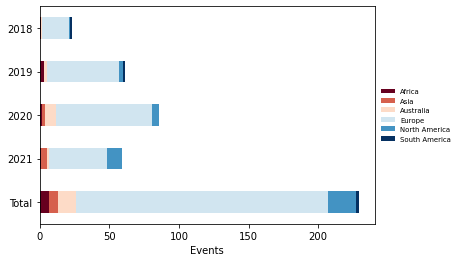

In [13]:
fig, ax = plt.subplots()
(continent_year_event_df
     .drop(['Total'], axis=1)
     .plot.barh(stacked=True, ax=ax, colormap='RdBu'))
plt.xlabel('Events')
ax.legend(
    loc='center left',
    bbox_to_anchor=(1, 0.5),
    frameon=False,
    fontsize='x-small')
plt.savefig('../images/tiaas-events-per-year.png', bbox_inches='tight')

In [14]:
continent_year_participants_df = pd.DataFrame(
    0,
    columns=list(df.continent.drop_duplicates().sort_values()) + ['Total'],
    index=['Total'] + list(df.year.drop_duplicates().sort_values(ascending=False)))
grouped_df = df.groupby(['year', 'continent'])
for g in grouped_df.groups:
    (y, c) = g
    continent_year_participants_df[c][y] = sum(grouped_df.get_group(g).attendance)
continent_year_participants_df.loc['Total'] = continent_year_participants_df.sum(axis=0)
continent_year_participants_df['Total'] = continent_year_participants_df.sum(axis=1)
continent_year_participants_df

,Africa,Asia,Australia,Europe,North America,South America,Total
Total,261,203,370,6994,503,80,8411
2021,20,123,76,2992,241,0,3452
2020,124,80,260,2271,182,0,2917
2019,101,0,24,1332,40,20,1517
2018,16,0,10,399,40,60,525


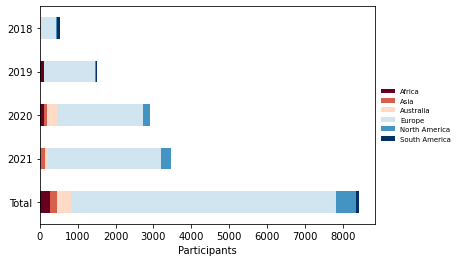

In [16]:
fig, ax = plt.subplots()
(continent_year_participants_df
     .drop(['Total'], axis=1)
     .plot.barh(stacked=True, ax=ax, colormap='RdBu'))
plt.xlabel('Participants')
ax.legend(
    loc='center left',
    bbox_to_anchor=(1, 0.5),
    frameon=False,
    fontsize='x-small')
plt.savefig('../images/tiaas-participants-per-year.png', bbox_inches='tight')